## FFT

A fast algorithm to calculate the DFT

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi kn/N}
$$
$$
x[n] = \frac{1}{2\pi}\sum_{k=0}^{N-1}X[k]e^{j2\pi kn/N}
$$
$my\_fft$ gets the original signal and the sampling rate as input and outputs the frequency and corresponding mag which is a complex number.

$my\_ifft$ gets the mag of the $my\_fft$ as input and outputs the original signal

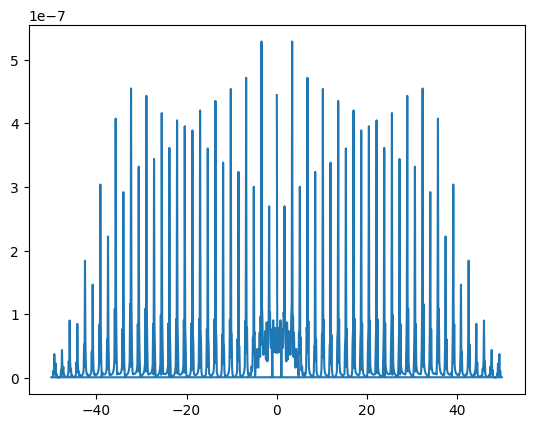

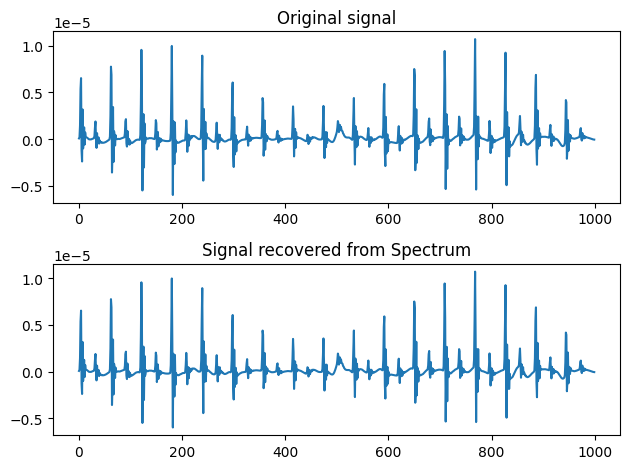

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.fft import fft,ifft,fftshift,fftfreq

def my_fft(signal, fs):
    l = len(signal)
    mag = fft(signal)
    freq = fftfreq(l, 1/fs)    
    mag = mag / l * 2  
    
    return freq, mag

def my_ifft(mag):
    mag = mag / 2 * len(mag)
    x = ifft(mag)
    
    return x

signal = np.load("../data/sim_100_0.1_90_140_train.npy")[1,:1000]
fs = 100

freq, mag = my_fft(signal, fs)
plt.plot(freq, np.abs(mag))
plt.show()

signal_recovered = my_ifft(mag)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Original signal")
axis[0].plot(signal)

axis[1].set_title("Signal recovered from Spectrum")
axis[1].plot(signal_recovered)
plt.tight_layout()
plt.show()

## Analytic Signal and Hilbert Transformation

Fourier Transform of a real-valued signal is complex-symmetric whose negative frequencies are redundant with respect to the positive frequencies. To remove the redundancy, the analytic signal is invented. It is complex-valued but its spectrum will be one-sided (only positive frequencies) that preserved the spectral content of the original real-valued signal. Using an analytic signal instead of the original real-valued signal, is useful in many signal processing applications. For example, in spectral analysis, use of analytic signal in-lieu of the original real-valued signal mitigates estimation biases and eliminates cross-term artifacts due to negative and positive frequency components.

In the frequency domain, the analytic signal has only the postive part of the original signal and the magnitude is two times of the orignal postive spectrum. In the time domain, the real part of the analytic signal is the same as the original signal, but it has a imaginary part. $z(t)$ denotes the time domain analytic singal, and $x(t)$ denotes the original signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + z_{i}(t)
$$
So what's the imaginary part? Hilbert Transformation can be used to find the imaginary part of the orignal real-valude signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
$$
HT\{x(t)\} = x(t) * \frac{1}{\pi t} \longleftrightarrow F(f)[-jsgn(f)] = \begin{cases}-jF(f) & f > 0 \\ jF(f) & f< 0 \end{cases}
$$
We can take the hilbert transformation as a filter whose impulse response is $\frac{1}{\pi t}$. And the HT\{x(t)\} has some properties.
1. HT\{HT\{x(t)\}\} = -x(t)
2. HT\{x(t)\} has the opposite parity of x(t)
3. HT\{x(t)\} and x(t) are orthogonal

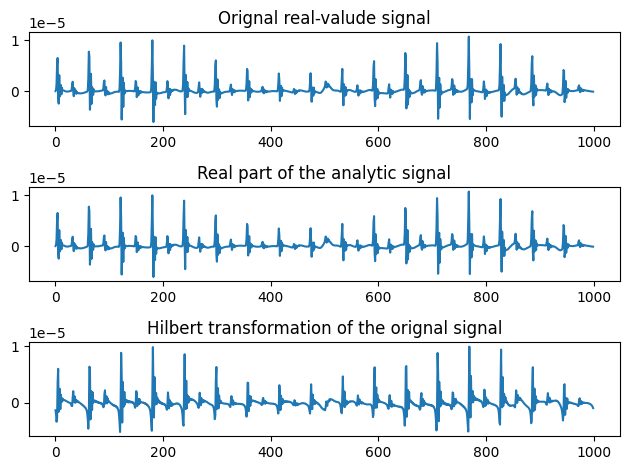

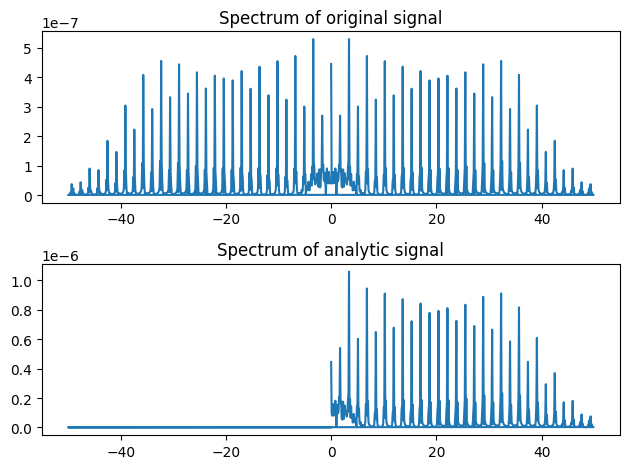

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft,ifft

def analytic_signal(x):
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def hilbert_transform(x):
    z = analytic_signal(x)
    return z.imag

signal = np.load("../data/sim_100_0.1_90_140_train.npy")[1,:1000]
z = analytic_signal(signal)

fig, axis = plt.subplots(3,1)
axis[0].set_title("Orignal real-valude signal")
axis[0].plot(signal)

axis[1].set_title("Real part of the analytic signal")
axis[1].plot(z.real)

axis[2].set_title("Hilbert transformation of the orignal signal")
axis[2].plot(hilbert_transform(signal))
plt.tight_layout()
plt.show()

freq_original, mag_original = my_fft(signal, 100)
freq_analytic, mag_analytic = my_fft(z, 100)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Spectrum of original signal")
axis[0].plot(freq_original, np.abs(mag_original))

axis[1].set_title("Spectrum of analytic signal")
axis[1].plot(freq_analytic, np.abs(mag_analytic))

plt.tight_layout()
plt.show()

## Extract envelope, phase using Hilbert transform

If a modulated signal is expressed as $x(t) = a(t) cos[ \phi (t)]$

The instantaneous amplitude or the envelope of the signal is given by $a(t)$

The instantaneous phase is given by  $\phi(t)$

The instantaneous angular frequency is derived as $\omega(t) = \frac{d}{dt} \phi(t)$

The instantaneous temporal frequency is derived as $f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t)$

We note that the modulated signal is a real-valued signal. We also take note of the fact that amplitude/phase and frequency can be easily computed if the signal is expressed in complex form. So we can use Hilbert transformation to transform the real-valued signal to a complex version.

The analytic signal is 
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
So
$$
a(t) = |z(t)| = \sqrt{z_r^2(t) + z_i^2(t)} 
$$
$$
\phi(t) = \angle z(t) = arctan \left[ \frac{z_i(t)}{z_r(t)} \right] 
$$
$$
f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t) 
$$

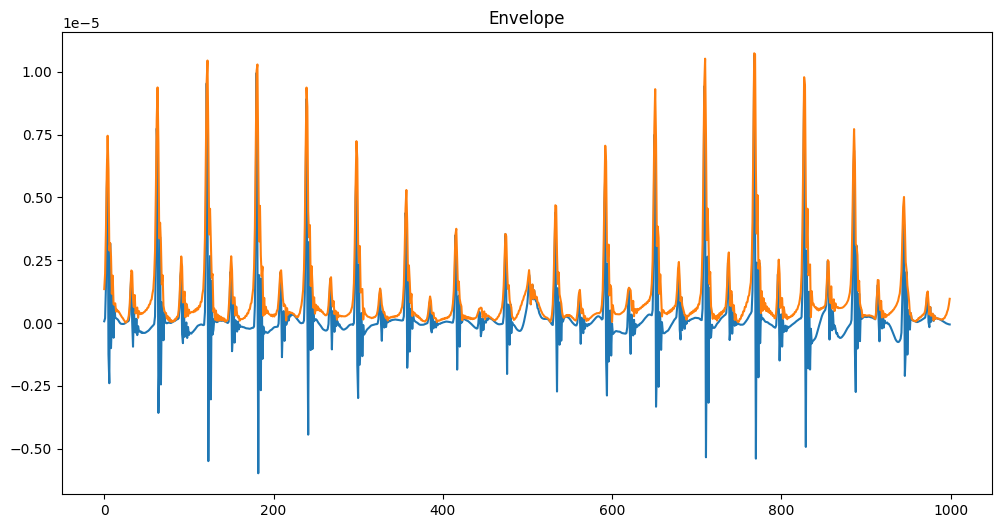

In [31]:
import numpy as np
import matplotlib.pyplot as plt


def inst_amplitude(signal):
    z = analytic_signal(signal)
    return np.abs(z)

def inst_phase(signal):
    z = analytic_signal(signal)
    return np.unwrap(np.angle(z))
    
def inst_freq(signal):
    z = analytic_signal(signal)
    return np.diff(inst_phase)/(2*np.pi)*fs


signal = np.load("../data/sim_100_0.1_90_140_train.npy")[1,:1000]

plt.figure(figsize=(12, 6))
plt.title("Envelope")
plt.plot(signal)
plt.plot(inst_amplitude(signal))
plt.show()

****************************loss is : tensor([1.9766e+08])
****************************loss is : tensor([2.1055e+08])
****************************loss is : tensor([1.7626e+08])
****************************loss is : tensor([1.7803e+08])
****************************loss is : tensor([1.8348e+08])
****************************loss is : tensor([2.1662e+08])
****************************loss is : tensor([1.8510e+08])
****************************loss is : tensor([1.6010e+08])
****************************loss is : tensor([90632384.])
****************************loss is : tensor([1.9638e+08])
****************************loss is : tensor([1.2848e+08])
****************************loss is : tensor([1.2253e+08])
****************************loss is : tensor([1.2168e+08])
****************************loss is : tensor([1.4837e+08])
****************************loss is : tensor([1.3961e+08])
****************************loss is : tensor([1.4161e+08])
****************************loss is : tensor([1.0321e+08]

****************************loss is : tensor([73919200.])
****************************loss is : tensor([43478044.])
****************************loss is : tensor([66641504.])
****************************loss is : tensor([82247680.])
****************************loss is : tensor([1.0987e+08])
****************************loss is : tensor([82272432.])
****************************loss is : tensor([1.0801e+08])
****************************loss is : tensor([64471000.])
****************************loss is : tensor([83338096.])
****************************loss is : tensor([78156304.])
****************************loss is : tensor([1.0523e+08])
****************************loss is : tensor([1.1242e+08])
****************************loss is : tensor([84469640.])
****************************loss is : tensor([79815120.])
****************************loss is : tensor([89182600.])
****************************loss is : tensor([94952496.])
****************************loss is : tensor([73615120.])
**********

****************************loss is : tensor([79742176.])
****************************loss is : tensor([77608264.])
****************************loss is : tensor([74684752.])
****************************loss is : tensor([55734492.])
****************************loss is : tensor([86317488.])
****************************loss is : tensor([67631936.])
****************************loss is : tensor([79622120.])
****************************loss is : tensor([66701776.])
****************************loss is : tensor([78297296.])
****************************loss is : tensor([73115712.])
****************************loss is : tensor([61113840.])
****************************loss is : tensor([93156040.])
****************************loss is : tensor([1.0478e+08])
****************************loss is : tensor([88200432.])
****************************loss is : tensor([1.0669e+08])
****************************loss is : tensor([72937312.])
****************************loss is : tensor([90844384.])
************

****************************loss is : tensor([70918920.])
****************************loss is : tensor([59150192.])
****************************loss is : tensor([1.0550e+08])
****************************loss is : tensor([86696616.])
****************************loss is : tensor([1.0446e+08])
****************************loss is : tensor([94915808.])
****************************loss is : tensor([66932204.])
****************************loss is : tensor([76071344.])
****************************loss is : tensor([78099968.])
****************************loss is : tensor([86686464.])
****************************loss is : tensor([80150096.])
****************************loss is : tensor([66469048.])
****************************loss is : tensor([91894784.])
****************************loss is : tensor([55390728.])
****************************loss is : tensor([55737248.])
****************************loss is : tensor([91776056.])
****************************loss is : tensor([52012480.])
************

****************************loss is : tensor([72424752.])
****************************loss is : tensor([76336600.])
****************************loss is : tensor([84257816.])
****************************loss is : tensor([57947464.])
****************************loss is : tensor([90413848.])
****************************loss is : tensor([68378464.])
****************************loss is : tensor([75969760.])
****************************loss is : tensor([81800200.])
****************************loss is : tensor([80542464.])
****************************loss is : tensor([72029896.])
****************************loss is : tensor([79535992.])
****************************loss is : tensor([55231740.])
****************************loss is : tensor([74095088.])
****************************loss is : tensor([81173240.])
****************************loss is : tensor([87017704.])
****************************loss is : tensor([1.2839e+08])
****************************loss is : tensor([71056264.])
*************

****************************loss is : tensor([1.0768e+08])
****************************loss is : tensor([69115912.])
****************************loss is : tensor([84387504.])
****************************loss is : tensor([88480952.])
****************************loss is : tensor([56082904.])
****************************loss is : tensor([91175920.])
****************************loss is : tensor([59432324.])
****************************loss is : tensor([73424048.])
****************************loss is : tensor([1.0877e+08])
****************************loss is : tensor([1.2192e+08])
****************************loss is : tensor([71794536.])
****************************loss is : tensor([78703328.])
****************************loss is : tensor([86303488.])
****************************loss is : tensor([72181840.])
****************************loss is : tensor([95814064.])
****************************loss is : tensor([89571328.])
****************************loss is : tensor([71353208.])
***********

/Users/darcy/anaconda3/envs/BP_Predict/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1000,) + inhomogeneous part.

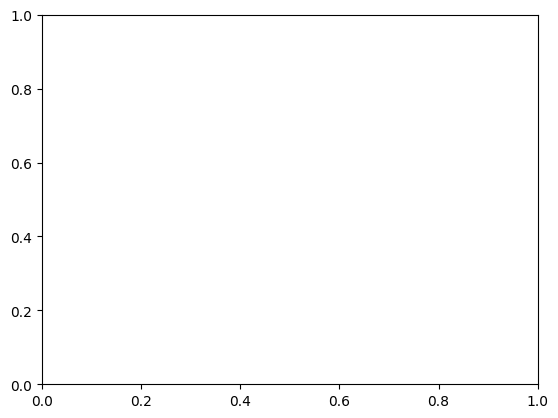

In [32]:
#coding=gbk

import torch
from torch.autograd import Variable
from torch.utils import data
import matplotlib.pyplot as plt

neuron_num=10
batch=32
sample_num=300
learn_rating=0.001
epoch=1000


x_data=torch.linspace(0,172,sample_num)
#print(x_data)

torch.manual_seed(10)

def function(x):
  return x*2+x**2+3
y_real=function(x_data)
#print(y_real)




def sampling(sample_num):
   
    #print(data_size)
    index_sequense=torch.randperm(sample_num)
    return index_sequense

w=torch.rand(neuron_num)
b=torch.randn(neuron_num)
w2=torch.randn(neuron_num)
b2=torch.randn(1)
def activation_function(x):
    return 1/(1+torch.sigmoid(-x))



def hidden_layer(w,b,x):
    return activation_function(w*x+b)

def  fully_connected_layer(w2,b2,x):
    return torch.dot(w2,x)+b2

def net(w,b,w2,b2,x):
    #print("w",w)
    #print("b",b)
    o1=hidden_layer(w,b,x)
    #print("o1",o1)
    #print("w2",w2)
    #print("b2",b2)
    o2=fully_connected_layer(w2,b2,o1)
 #   print("o2",o2)

    return o2

def get_grad(w,b,w2,b2,x,y_predict,y_real):
  

    o2=hidden_layer(w,b,x)

    l_of_w2=-(y_real-y_predict)*o2
    l_of_b2=-(y_real-y_predict)
    l_of_w=-(y_real-y_predict)*torch.dot(w2,o2*(1-o2))*x
    l_of_b=-(y_real-y_predict)*torch.dot(w2,o2*(1-o2))
    #print("grad")
    #print(l_of_w)
    #print(l_of_w2)
    #print(l_of_b)
    #print(l_of_b2)
    return l_of_w2,l_of_b2,l_of_w,l_of_b

def loss_function(y_predict,y_real):
    #print(y_predict,y_real)
    return torch.pow(y_predict-y_real,2)
loss_list=[]


def train():
    global w,w2,b,b2
    index=0
    for i in range(epoch):
        
        index_sequense=sampling(sample_num)
   
        W_g=torch.zeros(neuron_num)
        b_g=torch.zeros(neuron_num)
        W2_g=torch.zeros(neuron_num)
        b2_g=torch.zeros(1)
        loss=torch.tensor([0.0])
           
        for k in range(batch):
              try:
                   # print("x",x_data[index],index)
                   # print("w",w)
                        y_predict=net(w,b,w2,b2,x_data[index_sequense[index]])
                        #print("y_predict",y_predict)
                        #print("x:",x_data[index_sequense[index]])
                        #print("yreal:",y_real[index_sequense[index]])
                        get_grad(w,b,w2,b2,x_data[index_sequense[index]],y_predict,y_real[index_sequense[index]])
                      
                        l_of_w2,l_of_b2,l_of_w,l_of_b= get_grad(w,b,w2,b2,x_data[index_sequense[index]],y_predict,y_real[index_sequense[index]])
                        W_g=W_g+l_of_w
                        b_g=b_g+l_of_b
                        b2_g=b2_g+l_of_b2
                        W2_g=W2_g+l_of_w2
                        loss=loss+loss_function(y_predict,y_real[index_sequense[index]])
                        index=index+1
                       

              except:
                        index=0
                        index_sequense=sampling(sample_num)
        print("****************************loss is :",loss/batch)
        loss_list.append(loss/batch)
     
        W_g=W_g/batch
        b_g=b_g/batch
        b2_g=b2_g/batch
        W2_g=W2_g/batch
        w=w-learn_rating*W_g
        b=b-learn_rating*b_g
        w2=w2-learn_rating*W2_g
        b2=b2-learn_rating*b2_g
        #print(W2_g/batch)
        #print('w2',w2)
        #print(W_g/batch)
        #print('w1',w)


        


train()

y_predict=[]
for i in range(sample_num):

  y_predict.append(net(w,b,w2,b2,x_data[i]))

epoch_list=list(range(epoch))
plt.plot(epoch_list,loss_list,label='SGD')
plt.title("loss")
plt.legend()

plt.show()

plt.plot(x_data,y_real,label='real')
plt.plot(x_data,y_predict,label='predict')
plt.title(" Universal Theorem of Neural Networks")
plt.legend()
plt.show()
print(w,b,w2,b2)

